In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.preprocessing import image as ig
from tensorflow.keras.preprocessing.image import img_to_array
import random

In [17]:
train_dir = r"E:\Pythonworkshop\Dataset\Car_damage_detection_data\data1a\training"
test_dir = r"E:\Pythonworkshop\Dataset\Car_damage_detection_data\data1a\validation"

In [18]:
train_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1
)



#defining training set, here size of image is reduced to 150x150, batch of images is kept as 128 and class is defined as 'categorical'.
training_set = train_data.flow_from_directory(train_dir, batch_size = 32, target_size = (256,256), class_mode = 'categorical')

Found 1840 images belonging to 2 classes.


In [19]:
#applying same scale as training set, but only feature scaling is applied. image augmentation is avoided to prevent leakage of testing data.
test_data = ImageDataGenerator(rescale = 1./255)

#defining testing set
testing_set = test_data.flow_from_directory(test_dir, batch_size = 32, target_size = (256,256), class_mode = 'categorical')

Found 460 images belonging to 2 classes.


In [20]:
checkpoint = ModelCheckpoint(
    './base.model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)

opt1 = tf.keras.optimizers.Adam()

callbacks = [checkpoint,earlystop]

In [21]:
model = tf.keras.Sequential([
    # 第一组卷积层
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    # 第二组卷积层
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    # 第三组卷积层
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    
    # 第四组卷积层
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    
    # 全连接层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()
opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)
callbacks.append(reduce_lr)

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=opt1,
              metrics=['accuracy'])

# Fit the model
history = model.fit(
    training_set,
    epochs=50,  # 先设较短的训练周期
    steps_per_epoch=len(training_set),
    validation_data=testing_set,
    validation_steps=len(testing_set),
    callbacks=callbacks
)


e:\Pythonworkshop\damage_detection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,002 (1.62 MB)

 Trainable params: 422,786 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5387 - loss: 1.1230
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./base.model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.5387 - loss: 1.1216 - val_accuracy: 0.5000 - val_loss: 0.9431 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5581 - loss: 0.8817
Epoch 2: val_accuracy did not improve from 0.50000
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.5583 - loss: 0.8813 - val_accuracy: 0.5000 - val_loss: 0.9034 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6036 - loss: 0.8054
Epoch 3: val_accuracy did not improve from 0.50000
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6035 - loss: 0.8053 - val_accuracy: 0.5000 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6265 - loss: 0.7290
Epoch 4: val_accuracy did not improve from 0.5

In [22]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Weights Saved


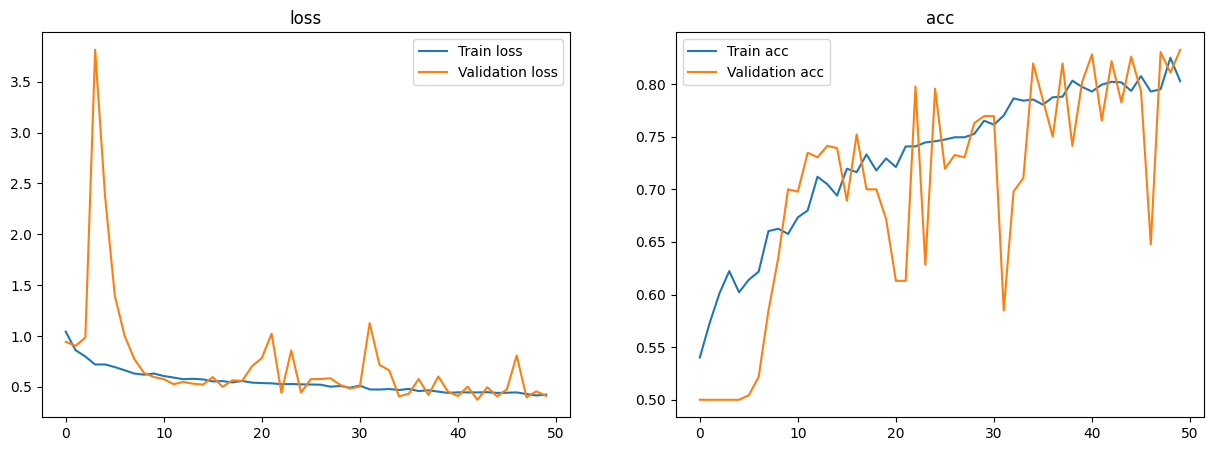

In [23]:
show_final_history(history)
model.save("model.keras")
print("Weights Saved")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


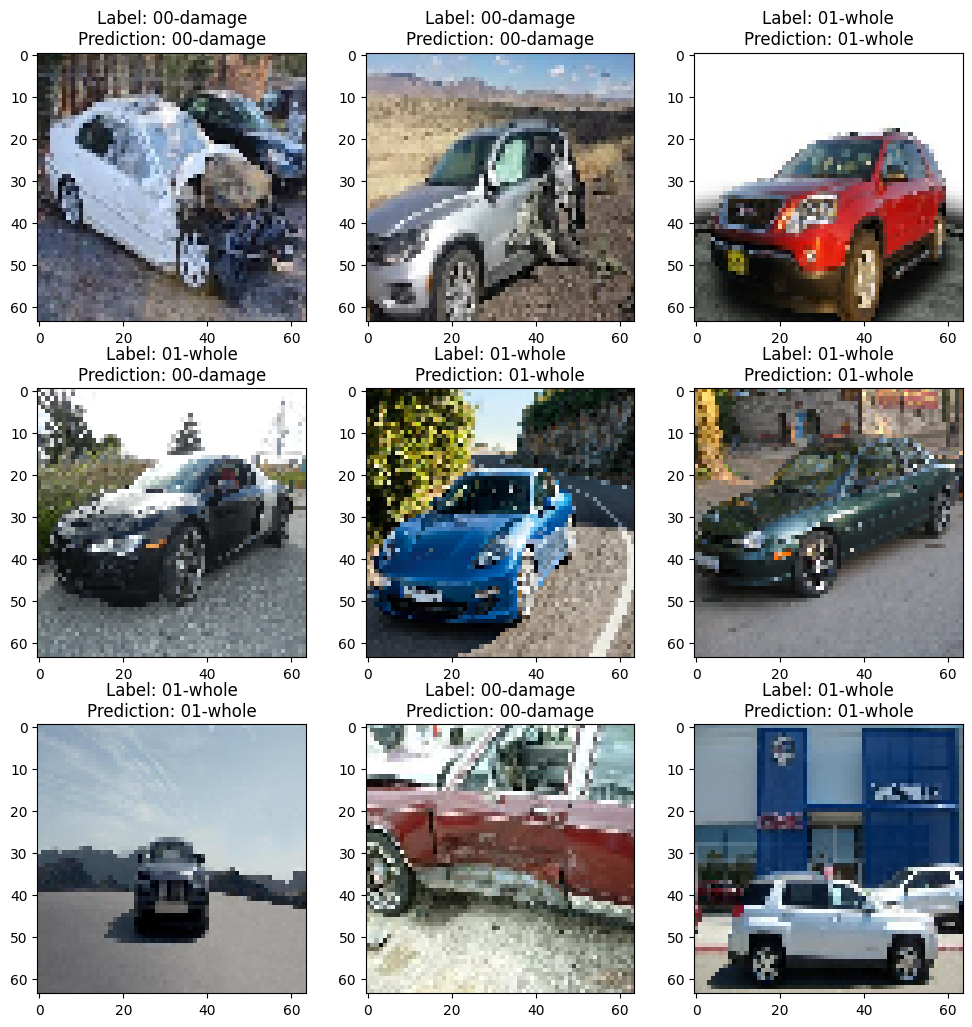

In [24]:
labels = ["00-damage","01-whole"]

it = iter(testing_set)
batch = next(it) # Gets a batch of 16 test images

fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.tight_layout()
fig.subplots_adjust(hspace=.25)

for i in range(3):
    for j in range(3):
        ax = axes[i,j]
        image = batch[0][i*3+j]
        net_input = image.reshape((1, 64, 64, 3))
        truth = np.argmax(batch[1][i*3+j])
        prediction = np.argmax(model.predict(net_input))
        ax.set_title('Label: %s\nPrediction: %s' % (labels[truth].capitalize(), labels[prediction].capitalize()))
        ax.imshow(image)

In [25]:
def custom_predictions(path):
    img = ig.load_img(path, target_size=(64, 64))
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    img.reshape(1,64,64,3)
    prediction = np.argmax(model.predict(img))
#     result=loaded_model.predict_classes(img)
    plt.title(labels[prediction])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


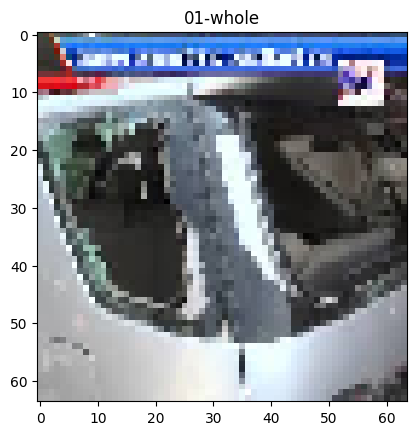

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


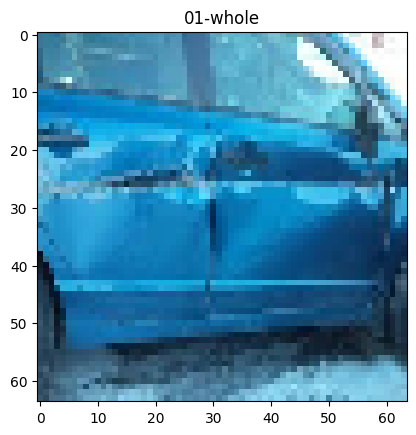

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


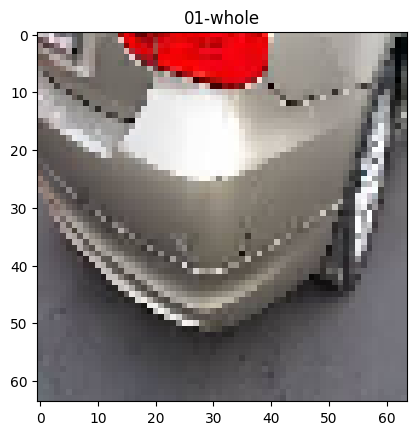

In [26]:
custom_predictions('E:/Pythonworkshop/Dataset/Car_damage_detection_data/data1a/training/00-damage/0001.JPEG')
custom_predictions('E:/Pythonworkshop/Dataset/Car_damage_detection_data/data1a/training/00-damage/0004.JPEG')
custom_predictions('E:/Pythonworkshop/Dataset/Car_damage_detection_data/data1a/training/00-damage/0007.JPEG')

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0
